# Customer Segmentation Using RFM Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('Online Retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
print('Missing values before cleaning:\n', df.isnull().sum())

Missing values before cleaning:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [5]:
df=df.dropna(subset=['CustomerID'])

In [14]:
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]

In [15]:
df['TotalPrice']=df['Quantity']*df['UnitPrice']

In [16]:
print('Missing values after cleaning:\n',df.isnull().sum())

Missing values after cleaning:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


In [17]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'],errors='coerce')
print(df['InvoiceDate'].dtype)

datetime64[ns]


In [18]:
snapshot_date=df['InvoiceDate'].max()+pd.Timedelta(days=1)
rfm=df.groupby('CustomerID').agg({
    'InvoiceDate':lambda x:(snapshot_date-x.max()).days,
    'InvoiceNo':'nunique',
    'TotalPrice':'sum'   
})
rfm.columns=['Recency','Frequency','Monetary']
print(rfm.head())

            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1  77183.60
12347.0           2          7   4310.00
12348.0          75          4   1797.24
12349.0          19          1   1757.55
12350.0         310          1    334.40


In [19]:
rfm['Recency_score']=pd.qcut(rfm['Recency'],4,labels=[4,3,2,1])
rfm['Frequency_score']=pd.qcut(rfm['Frequency'].rank(method="first"),4,labels=[1,2,3,4])
rfm['Monetary_score']=pd.qcut(rfm['Monetary'],4,labels=[1,2,3,4])
rfm['RFM_Score']=rfm[['Recency_score','Frequency_score','Monetary_score']].sum(axis=1)
print(rfm.head())

            Recency  Frequency  Monetary Recency_score Frequency_score  \
CustomerID                                                               
12346.0         326          1  77183.60             1               1   
12347.0           2          7   4310.00             4               4   
12348.0          75          4   1797.24             2               3   
12349.0          19          1   1757.55             3               1   
12350.0         310          1    334.40             1               1   

           Monetary_score  RFM_Score  
CustomerID                            
12346.0                 4          6  
12347.0                 4         12  
12348.0                 4          9  
12349.0                 4          8  
12350.0                 2          4  


In [20]:
def segment(x):
    if x>=9:
        return 'Champions'
    elif x>=7:
        return 'Loyal Customers'    
    elif x>=5:
        return 'Potential Loyalist'
    else:
        return 'At Risk'       
rfm['Segment']=rfm['RFM_Score'].apply(segment)
rfm['Segment'].value_counts()

Segment
Champions             1679
Potential Loyalist     988
Loyal Customers        864
At Risk                807
Name: count, dtype: int64

In [24]:
marketing_dict={
    'Champions': "Send VIP offers, early access to new products, thank-you gifts.",
    'Loyal Customers': "Offer loyalty programs, discounts, personalized product suggestions.",
    'Potential Loyalist': "Send coupons, reminder emails, special promotions to convert them.",
    'At Risk': "Re-engage with 'We miss you' campaigns, big discounts, or surveys."
}
rfm['Marketing_Action'] = rfm['Segment'].map(marketing_dict)
print(rfm[['Recency','Frequency','Monetary','Segment','Marketing_Action']].head())

            Recency  Frequency  Monetary             Segment  \
CustomerID                                                     
12346.0         326          1  77183.60  Potential Loyalist   
12347.0           2          7   4310.00           Champions   
12348.0          75          4   1797.24           Champions   
12349.0          19          1   1757.55     Loyal Customers   
12350.0         310          1    334.40             At Risk   

                                             Marketing_Action  
CustomerID                                                     
12346.0     Send coupons, reminder emails, special promoti...  
12347.0     Send VIP offers, early access to new products,...  
12348.0     Send VIP offers, early access to new products,...  
12349.0     Offer loyalty programs, discounts, personalize...  
12350.0     Re-engage with 'We miss you' campaigns, big di...  


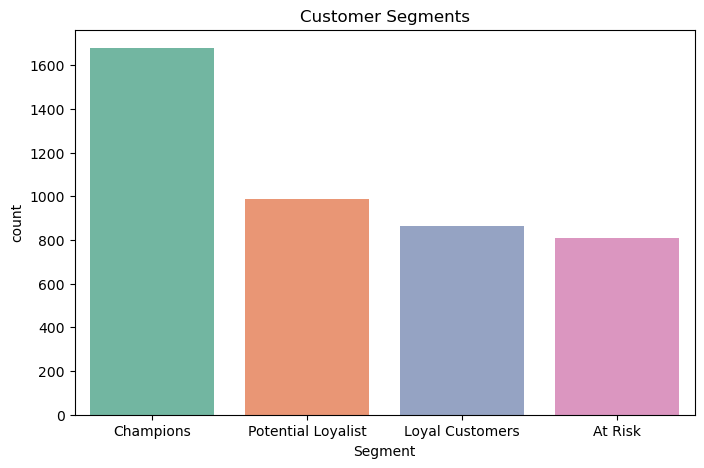

In [21]:
plt.figure(figsize=(8,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette="Set2")
plt.title("Customer Segments")
plt.show()